In [153]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import pickle

### Simulazione del prezzo dei singoli sottostanti del Basket secondo modello di BS

Algoritmo per la simulazione di un $GBM(\mu,\Sigma)$ (con $\Sigma$ matrice di covarianza) ai tempi $0=t_0<t_1<...<t_n$:
$$ S_i(t_{k+1}) = S_i(t_k) \exp\left[\left(\mu_i-\frac{1}{2}\sigma_i^2\right)\left(t_{k+1}-t_k\right)+\sqrt{t_{k+1}-t_k}\sum_{j=1}^d A_{ij}Z_{k+1,j}\right]$$

dove $k = 0,...,n-1$, $A$ matrice tale per cui $\Sigma = A A^{T}$ (fattorizzazione di Cholesky), $Z_k = (Z_{k1},...,Z_{kd})\sim N(0,I)$ e $Z_1,Z_2,...,Z_n$ sono indipendenti

In [18]:
def Gauss_d_dim_Step(x):
    for i in range (len(x)):
        x[i] = rnd.gauss(0,1)
    return x


def GBM_d(drift,vol,s_i_t,step,a,dt):   #con s_i_t intendo la riga dei prezzi al tempo t dei vari sottostanti, dt è il passo temporale, a la matrice ottenuta dalla fattorizzazione di Cholesky, step il vettore degli incrementi gaussiani standard
    x = (drift-0.5*vol)*dt+np.sqrt(dt)*np.sum(step*a,axis=1) #axis = 1 sommo su tutta la riga
    s_i_t_new = s_i_t*np.exp(x)  #riga dei prezzi al tempo t+1
    return s_i_t_new



In [245]:
#Funzione analisi risultati simulazioni Monte Carlo
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def Data_Blocking_Analysis(data,N): #data=array dati N = number of block
    M= len(data)              # Total number of throws
    L=int(M/N)            # Number of throws in each block, please use for M a multiple of N
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)
    x = np.arange(N)
    x*=L
    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += data[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
    
    return x, sum_prog, err_prog  #number of throws, mean, error

#### Calibrazione del Basket
(i valori inseriti sono di prova, il modello verrà calibrato nella cella successiva leggendo da file)

Struttura del codice:
- $d$ è il numero dei sottostanti del basket
- $T$ data di maturità
- $S_t$ è la matrice dell'andamento dei singoli sottostanti ai vari tempi:$$S_t=\begin{bmatrix}
S_{t_0}^1 & S_{t_0}^2& ...& S_{t_0}^d \\
S_{t_1}^1 & & &\\
   . & & &\\
   . & & &\\
   .& & &\\
   S_{t_T}^1 & & & S_{t_T}^d\\
\end{bmatrix}
$$
- Le singole date $t_i$ possono essere ricavate attraverso il numero della riga
- La variabile vol indica il vettore delle volatilità dei singoli sottostanti:
$$vol = \sigma^2=\begin{bmatrix}
\sigma_1^2  \\
\sigma_2^2\\
   .\\
   . \\
   .\\
   \sigma_d^2\\
\end{bmatrix}
$$
- La matrice rho indica la matrice di correlazione:
 $$\rho=\begin{bmatrix}
\rho_{11} & \rho_{12}& ...& \rho_{1d} \\
\rho_{21} & & & \\
   . & & &\\
   . & & &\\
   .& & &\\
   \rho_{d1} & & & \rho_{dd}\\
\end{bmatrix}
$$

- La matrice $\Sigma$ indica la matrice di covarianza: $\Sigma_{ij} = \sigma_i\sigma_j \rho_{ij}$ 

In [19]:
d = 2 #numero di sottostanti
T = 365 #expiry (1 anno)
dt = 1 #step temporali (daily)
n = int(T/dt)
r = 0.1 #interest rate
div_rate = np.zeros(d)
S_0 = np.zeros(d) #vettore dei prezzi iniziali
S_t = np.zeros((n,d))  #matrice dei path dei sottostanti nel tempo
vol = np.zeros(d)   #vettore delle volatilità
rho = np.zeros((d,d))  #matrice di correlazione

#### Lettura da file per la calibrazione

In [264]:
#codice dove carico da file i dati 
#error = np.loadtxt('polo.txt',  usecols=(0,1,2),delimiter=' ', unpack='faulse')  #lettura da file
#error= error.T  per mettere a posto la matrice

#### Preparazione di alcune variabili utili alla simulazione
Decomposizione di Cholesky della matrice di correlazione e inizializzazione degli spot price al tempo $t=0$

La decomposizione di Cholesky prevede la fattorizzazione della matrice di covarianza in una matrice $A$ tale per cui $\Sigma = A A^{T}$

In [21]:
Z = np.zeros(d) #vettore variabili casuali indipendenti distribuite secondo gaussiana standard 
Vol = vol*np.identity(d)
Sigma = np.array(([0.25,0],[0,0.01]))
A = np.linalg.cholesky(Sigma) #cholesky factorization
S_t[0][:] = S_0  #definisco nella matrice i spot price iniziali

#### Simulazione di prova per un numero di sottostanti d=2 non correlati
Parametri di prova:
- prezzo degli asset a $t=0$: $S_1(0)=100$ e $S_2(0)=150$
- maturity: $T=1$
- tasso di interesse privo di rischio: $r=0.1$
- passo di sampling $dt = 0.01$
- Matrice di covarianza (sottostanti non correlati): $$\Sigma=\begin{bmatrix}
0.25 & 0 \\
0 & 0.13 \\
\end{bmatrix}
$$

In [277]:
d = 2
T = 1
dt = 0.01
n = int(T/dt)+1
r = 0.1 
S_0 = np.array([100,100]) 
S_t = np.zeros((n,d)) 
vol = np.array([0.25,0.14]) 
rho = np.identity(d) 
Sigma = vol*rho
#Sigma = np.array([[0.25,0.01],[0.01,0.13]])

In [278]:
Z = np.zeros(d) 
A = np.linalg.cholesky(Sigma) 
S_t[0][:] = S_0 

In [279]:
for i in range (1,n):
    Z = Gauss_d_dim_Step(Z)
    S_t[i][:] = GBM_d(r,vol,S_t[i-1][:],Z,A,dt)

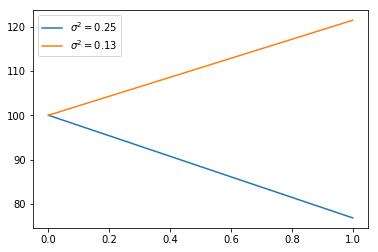

In [280]:
t = np.linspace(0,T,n)

plt.plot(t,S_t.T[0], label = "$\sigma^2 = 0.25$")
plt.plot(t,S_t.T[1],label = "$\sigma^2= 0.13$")
plt.legend()
print()

#### Prova di pricing call europea
Prova del calcolo di una call europea sul sottostante $S^1_t$con strike price $K = 100$ e expiry $T=1$

In [281]:
K = 100
M = 100000 #numero di simulazioni MC
S_t = np.zeros((n,d)) 
S_t[0][:] = S_0 
Call = np.zeros(M)
for j in range (M):
    for i in range (1,n):
        Z = Gauss_d_dim_Step(Z)
        S_t[i][:] = GBM_d(r,vol,S_t[i-1][:],Z,A,dt)
    Call[j] = max(S_t[len(S_t)-1][1]-K,0)
    #np.savetxt("Path"+str(j),S_t) per salvare su file


In [282]:
S0 = 100.
K = 100.
T = 1.
r = 0.1
vol = 0.14#0.25
sigma = np.sqrt(vol)
t=0

def N(x):
    return 0.5 * (1. + np.erf(x / np.sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (vol) / 2.) * T)
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    return C

if __name__ == "__main__":
    call= black_scholes(S0, K, T, r, sigma)
    print(" == Soluzione analitica da BLACK-SCHOLES ==")
    print("call: ", call)
    

    

 == Soluzione analitica da BLACK-SCHOLES ==
call:  19.387906447150968


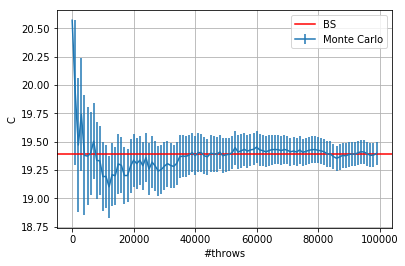

In [283]:
N = 100
x,C,err = Data_Blocking_Analysis(Call*np.exp(-r*T),N)
plt.axhline(y=call, color = 'red',linestyle='-',label = 'BS')
plt.errorbar(x,C,yerr=err,label = 'Monte Carlo')
plt.xlabel('#throws')
plt.ylabel('C')
plt.grid(True)
plt.legend()
plt.show()

In [196]:
#error = np.loadtxt('polo.txt',  usecols=(0,1,2),delimiter=' ', unpack='faulse')  #lettura da file
#error= error.T  per mettere a posto la matrice
#np.savetxt("polo.txt",S_t) scrivere su file